# Movimentos e Colisões 

### 📦 Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import random

## 1. Simulação das Medições Irregulares (Gabriel) 

Isso também pode ser chamado de Simulação de falhas e Tratamento de Dados Irregulares. 
   
Criamos uma função para simular a trajetória verdadeira de um móvel e, em seguida, simular as falhas de medição, resultando em uma série de dados esparsa e irregular.



Móvel A: 178 medições bem-sucedidas.
Móvel B: 186 medições bem-sucedidas.


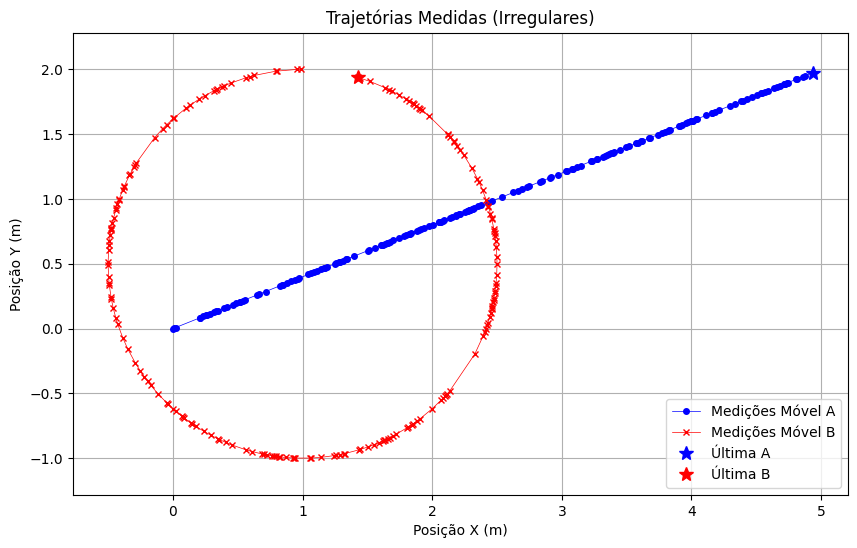

In [4]:
def gerar_trajetoria_verdadeira_exemplo(tempos, tipo='reta_vel_constante'):
    """
    Gera uma trajetória 2D 'verdadeira' para um conjunto de tempos.

    Args:
        tempos (np.ndarray): Array de tempos.
        tipo (str): Tipo de trajetória ('reta_vel_constante', 'circular').

    Returns:
        np.ndarray: Array de posições [N, 2] (colunas x, y).
    """
    posicoes = np.zeros((len(tempos), 2))
    if tipo == 'reta_vel_constante':
        v0 = np.array([0.5, 0.2]) # m/s (velocidade constante)
        r0 = np.array([0.0, 0.0]) # m (posição inicial)
        for i, t in enumerate(tempos):
            posicoes[i] = r0 + v0 * t
    elif tipo == 'circular':
        raio = 2.0 # m
        omega = 0.5 # rad/s (velocidade angular)
        centro = np.array([0.0, 2.0]) # m
        for i, t in enumerate(tempos):
            angulo = omega * t
            posicoes[i, 0] = centro[0] + raio * np.cos(angulo)
            posicoes[i, 1] = centro[1] + raio * np.sin(angulo)
    # Adicionar um pouco de ruído gaussiano leve à trajetória real (opcional)
    # posicoes += np.random.randn(*posicoes.shape) * 0.01
    return posicoes

def simular_medicoes(T_max, dt_regular, p_falha, fn_trajetoria_verdadeira, args_trajetoria=None):
    """
    Simula medições irregulares devido a falhas.

    Args:
        T_max (float): Tempo máximo da simulação.
        dt_regular (float): Intervalo de tempo das medições *antes* das falhas.
        p_falha (float): Probabilidade de uma medição falhar (0 a 1).
        fn_trajetoria_verdadeira (callable): Função que gera a trajetória verdadeira.
        args_trajetoria (dict, optional): Argumentos para a função de trajetória.

    Returns:
        tuple: (tempos_medidos, posicoes_medidas_xy)
               np.ndarray, np.ndarray [M, 2] onde M <= N
    """
    if args_trajetoria is None:
        args_trajetoria = {}

    tempos_regulares = np.arange(0, T_max, dt_regular)
    posicoes_verdadeiras = fn_trajetoria_verdadeira(tempos_regulares, **args_trajetoria)

    tempos_medidos_lista = []
    posicoes_medidas_lista = []

    for t, pos in zip(tempos_regulares, posicoes_verdadeiras):
        if np.random.rand() >= p_falha: # Medição bem-sucedida
            tempos_medidos_lista.append(t)
            posicoes_medidas_lista.append(pos)

    if not tempos_medidos_lista: # Se todas falharam
         return np.array([]), np.empty((0,2))

    return np.array(tempos_medidos_lista), np.array(posicoes_medidas_lista)

# --- Parâmetros da Simulação ---
T_MAX = 10.0 # segundos
DT_REGULAR = 0.01 # segundos (intervalo base)
P_FALHA = 0.80 # 80% de probabilidade de falha
N_INTERP = 4    # Usar as últimas N medições para interpolação (grau N-1)

# --- Simular para Móvel A (Reta) ---
tempos_A, posicoes_A = simular_medicoes(
    T_MAX, DT_REGULAR, P_FALHA,
    gerar_trajetoria_verdadeira_exemplo, args_trajetoria={'tipo': 'reta_vel_constante'}
)

# --- Simular para Móvel B (Circular) ---
# Ajustar trajetória de B para potencial colisão
def gerar_trajetoria_B(tempos):
     # Movimento circular diferente para B
     posicoes = np.zeros((len(tempos), 2))
     raio = 1.5
     omega = 0.6
     centro = np.array([1.0, 0.5])
     for i, t in enumerate(tempos):
         angulo = omega * t + np.pi/2 # Começa em outra fase
         posicoes[i, 0] = centro[0] + raio * np.cos(angulo)
         posicoes[i, 1] = centro[1] + raio * np.sin(angulo)
     return posicoes

tempos_B, posicoes_B = simular_medicoes(
    T_MAX, DT_REGULAR, P_FALHA,
    gerar_trajetoria_B
)

print(f"Móvel A: {len(tempos_A)} medições bem-sucedidas.")
print(f"Móvel B: {len(tempos_B)} medições bem-sucedidas.")

# --- Visualização das medições (opcional) ---
plt.figure(figsize=(10, 6))
plt.plot(posicoes_A[:, 0], posicoes_A[:, 1], 'bo-', label='Medições Móvel A', markersize=4, linewidth=0.5)
plt.plot(posicoes_B[:, 0], posicoes_B[:, 1], 'rx-', label='Medições Móvel B', markersize=4, linewidth=0.5)
if len(posicoes_A)>0:
    plt.plot(posicoes_A[-1, 0], posicoes_A[-1, 1], 'b*', markersize=10, label='Última A')
if len(posicoes_B)>0:
    plt.plot(posicoes_B[-1, 0], posicoes_B[-1, 1], 'r*', markersize=10, label='Última B')
plt.title('Trajetórias Medidas (Irregulares)')
plt.xlabel('Posição X (m)')
plt.ylabel('Posição Y (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

##  2. Estimativa de estado por interpolação (Gean) e (Julia e Isabela, na parte de estimar a posição)

Não faz tanto sentido separar essa parte dado que o produto final do estado é estimar posição, velocidade e aceleração. 

    Esta função recebe as últimas `n` medições (tempo e posição) e calcula os polinômios interpoladores para x e y. Em seguida, calcula os coeficientes das derivadas e avalia todos os polinômios no tempo desejado para obter $\vec{r}(t)$, $\vec{v}(t)$, $\vec{a}(t)$.
    


--- Estimando estado do Móvel A em t=9.87s usando 4 pontos ---
Posição A estimada: (4.935, 1.974) m
Velocidade A estimada: (0.500, 0.200) m/s
Aceleração A estimada: (0.000, 0.000) m/s^2

--- Estimando estado do Móvel B em t=9.99s usando 4 pontos ---
Posição B estimada: (1.428, 1.938) m
Velocidade B estimada: (-0.863, 0.257) m/s
Aceleração B estimada: (-0.154, -0.518) m/s^2


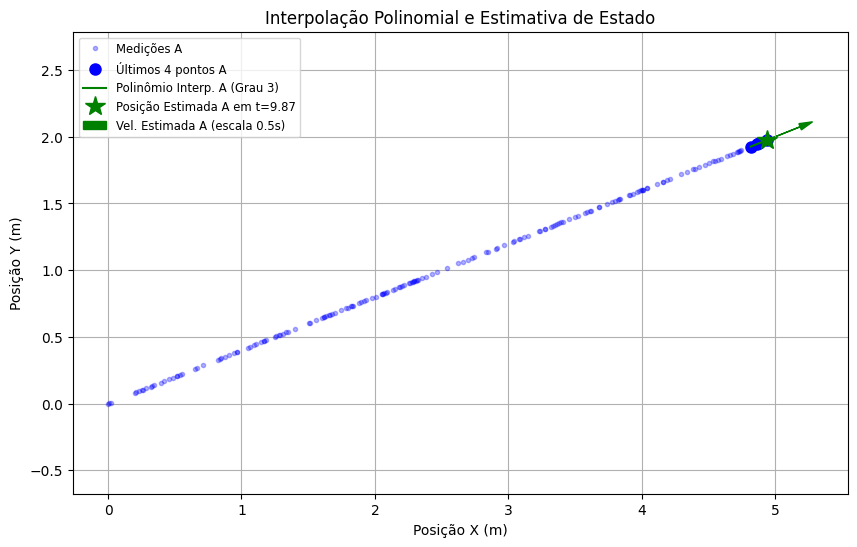

In [ ]:
def estimar_estado_polinomial(tempos_ultimos_n, posicoes_ultimas_n_xy, tempo_estimativa):
    """
    Estima posição, velocidade e aceleração usando interpolação polinomial
    baseada nas últimas n medições.

    Args:
        tempos_ultimos_n (np.ndarray): Array com os N últimos tempos.
        posicoes_ultimas_n_xy (np.ndarray): Array [N, 2] com as posições XY.
        tempo_estimativa (float): Instante de tempo para o qual estimar o estado.

    Returns:
        tuple: (pos_estimada, vel_estimada, acc_estimada)
               Todos são np.ndarray [2] (vetores [x, y]).
               Retorna (None, None, None) em caso de erro (e.g., poucos pontos, matriz singular).
    """
    n = len(tempos_ultimos_n)
    if n < 2:
        print("Erro: Menos de 2 pontos, não é possível interpolar.")
        return None, None, None
    if n < 3:
         # Aviso: Aceleração não pode ser estimada com menos de 3 pontos
         # (polinômio de grau < 2). Poderíamos retornar aceleração zero ou NaN.
         # Por simplicidade, vamos prosseguir mas a aceleração será [0,0] se n=2.
         print("Aviso: Menos de 3 pontos, estimativa de aceleração será [0,0].")
         pass


    x_ultimos_n = posicoes_ultimas_n_xy[:, 0]
    y_ultimos_n = posicoes_ultimas_n_xy[:, 1]

    # Construir a matriz de Vandermonde
    # Nota: np.vander(t, N) cria colunas t^(N-1), t^(N-2), ..., t^0
    # que é a ordem esperada por np.polyfit, np.polyval, np.polyder.
    V = np.vander(tempos_ultimos_n, N=n)

    try:
        # Resolver os sistemas lineares V*c = x e V*c = y
        coeffs_x = np.linalg.solve(V, x_ultimos_n) # Coefs: [c_{n-1}, ..., c_0]
        coeffs_y = np.linalg.solve(V, y_ultimos_n)
    except np.linalg.LinAlgError:
        print("Erro: Matriz de Vandermonde singular. Não foi possível resolver.")
        # Isso pode acontecer se os tempos forem muito próximos ou idênticos.
        return None, None, None

    # Calcular coeficientes das derivadas
    coeffs_vx = np.polyder(coeffs_x, m=1)
    coeffs_vy = np.polyder(coeffs_y, m=1)
    coeffs_ax = np.polyder(coeffs_x, m=2) # Derivada segunda
    coeffs_ay = np.polyder(coeffs_y, m=2)

    # Avaliar os polinômios no tempo desejado - (Julia e Isabela faz essa parte de estimar a posição)
    pos_estimada = np.array([
        np.polyval(coeffs_x, tempo_estimativa),
        np.polyval(coeffs_y, tempo_estimativa)
    ])
    vel_estimada = np.array([
        np.polyval(coeffs_vx, tempo_estimativa),
        np.polyval(coeffs_vy, tempo_estimativa)
    ])
    acc_estimada = np.array([
        np.polyval(coeffs_ax, tempo_estimativa),
        np.polyval(coeffs_ay, tempo_estimativa)
    ])

    # Lidar com caso n=2 onde polyder(m=2) retorna vazio ou 0.0
    if n == 2:
        acc_estimada = np.array([0.0, 0.0])


    return pos_estimada, vel_estimada, acc_estimada

# --- Exemplo de uso ---
# Pegar as últimas N medições de A (se houver N ou mais)
if len(tempos_A) >= N_INTERP:
    t_ultimos_A = tempos_A[-N_INTERP:]
    pos_ultimas_A = posicoes_A[-N_INTERP:]
    t_estimativa_A = t_ultimos_A[-1] # Estimar no tempo da última medição

    print(f"\n--- Estimando estado do Móvel A em t={t_estimativa_A:.2f}s usando {N_INTERP} pontos ---")
    r_A, v_A, a_A = estimar_estado_polinomial(t_ultimos_A, pos_ultimas_A, t_estimativa_A)

    if r_A is not None:
        print(f"Posição A estimada: ({r_A[0]:.3f}, {r_A[1]:.3f}) m")
        print(f"Velocidade A estimada: ({v_A[0]:.3f}, {v_A[1]:.3f}) m/s")
        print(f"Aceleração A estimada: ({a_A[0]:.3f}, {a_A[1]:.3f}) m/s^2")
else:
    print(f"\nMóvel A não tem medições suficientes ({len(tempos_A)} < {N_INTERP}) para estimar.")
    r_A, v_A, a_A = None, None, None

# Repetir para B
if len(tempos_B) >= N_INTERP:
    t_ultimos_B = tempos_B[-N_INTERP:]
    pos_ultimas_B = posicoes_B[-N_INTERP:]
    t_estimativa_B = t_ultimos_B[-1]

    print(f"\n--- Estimando estado do Móvel B em t={t_estimativa_B:.2f}s usando {N_INTERP} pontos ---")
    r_B, v_B, a_B = estimar_estado_polinomial(t_ultimos_B, pos_ultimas_B, t_estimativa_B)

    if r_B is not None:
        print(f"Posição B estimada: ({r_B[0]:.3f}, {r_B[1]:.3f}) m")
        print(f"Velocidade B estimada: ({v_B[0]:.3f}, {v_B[1]:.3f}) m/s")
        print(f"Aceleração B estimada: ({a_B[0]:.3f}, {a_B[1]:.3f}) m/s^2")
else:
    print(f"\nMóvel B não tem medições suficientes ({len(tempos_B)} < {N_INTERP}) para estimar.")
    r_B, v_B, a_B = None, None, None

# --- Visualizar estimativa (opcional) ---
# Plotar a curva polinomial interpolada sobre os pontos usados
if r_A is not None:
    V_A = np.vander(t_ultimos_A, N=N_INTERP)
    coeffs_xA = np.linalg.solve(V_A, pos_ultimas_A[:,0])
    coeffs_yA = np.linalg.solve(V_A, pos_ultimas_A[:,1])
    t_plot = np.linspace(t_ultimos_A[0], t_ultimos_A[-1], 100)
    x_plot_A = np.polyval(coeffs_xA, t_plot)
    y_plot_A = np.polyval(coeffs_yA, t_plot)

    plt.figure(figsize=(10, 6))
    plt.plot(posicoes_A[:, 0], posicoes_A[:, 1], 'b.', label='Medições A', alpha=0.3)
    plt.plot(pos_ultimas_A[:, 0], pos_ultimas_A[:, 1], 'bo', markersize=8, label=f'Últimos {N_INTERP} pontos A')
    plt.plot(x_plot_A, y_plot_A, 'g-', label=f'Polinômio Interp. A (Grau {N_INTERP-1})')
    plt.plot(r_A[0], r_A[1], 'g*', markersize=15, label=f'Posição Estimada A em t={t_estimativa_A:.2f}')
    # Adicionar vetor velocidade
    plt.arrow(r_A[0], r_A[1], v_A[0]*0.5, v_A[1]*0.5, head_width=0.05, head_length=0.1, fc='green', ec='green', label='Vel. Estimada A (escala 0.5s)')

    # Fazer o mesmo para B se disponível
    if r_B is not None and t_estimativa_A == t_estimativa_B: # Plotar B apenas se tivermos dados
        V_B = np.vander(t_ultimos_B, N=N_INTERP)
        coeffs_xB = np.linalg.solve(V_B, pos_ultimas_B[:,0])
        coeffs_yB = np.linalg.solve(V_B, pos_ultimas_B[:,1])
        t_plot_B = np.linspace(t_ultimos_B[0], t_ultimos_B[-1], 100)
        x_plot_B = np.polyval(coeffs_xB, t_plot_B)
        y_plot_B = np.polyval(coeffs_yB, t_plot_B)
        plt.plot(posicoes_B[:, 0], posicoes_B[:, 1], 'r.', label='Medições B', alpha=0.3)
        plt.plot(pos_ultimas_B[:, 0], pos_ultimas_B[:, 1], 'ro', markersize=8, label=f'Últimos {N_INTERP} pontos B')
        plt.plot(x_plot_B, y_plot_B, 'm-', label=f'Polinômio Interp. B (Grau {N_INTERP-1})')
        plt.plot(r_B[0], r_B[1], 'm*', markersize=15, label=f'Posição Estimada B em t={t_estimativa_B:.2f}')
        plt.arrow(r_B[0], r_B[1], v_B[0]*0.5, v_B[1]*0.5, head_width=0.05, head_length=0.1, fc='magenta', ec='magenta', label='Vel. Estimada B (escala 0.5s)')


    plt.title('Interpolação Polinomial e Estimativa de Estado')
    plt.xlabel('Posição X (m)')
    plt.ylabel('Posição Y (m)')
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

## 3. Detecção de Colisão e Otimização (Vinicius)

    Esta função verifica se há colisão atual ou prevista (usando extrapolação linear) entre dois móveis, dadas suas posições e velocidades estimadas.
    

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.



--- Verificando Colisão (Raio=0.10m, Previsão=0.5s) ---
Distância Atual: 3.507 m
Situação Atual: Sem colisão.
Distância Prevista em 0.5s: 4.189 m
Situação Prevista (0.5s): Sem colisão.


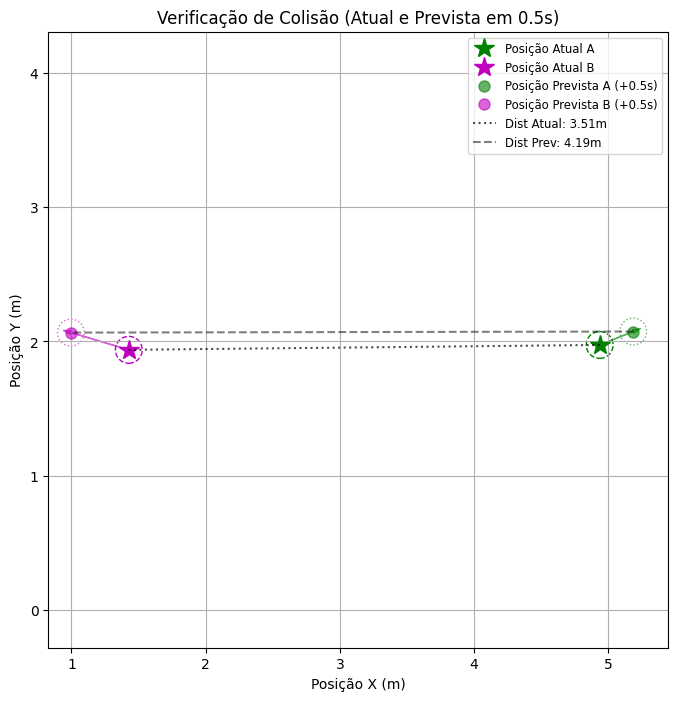

In [6]:
def verificar_colisao(pos_A, vel_A, pos_B, vel_B, raio, delta_t_pred):
    """
    Verifica colisão atual e prevista entre dois móveis circulares.

    Args:
        pos_A (np.ndarray): Posição estimada [x, y] do móvel A.
        vel_A (np.ndarray): Velocidade estimada [vx, vy] do móvel A.
        pos_B (np.ndarray): Posição estimada [x, y] do móvel B.
        vel_B (np.ndarray): Velocidade estimada [vx, vy] do móvel B.
        raio (float): Raio dos móveis (assumido igual para ambos).
        delta_t_pred (float): Horizonte de tempo para previsão de colisão.

    Returns:
        tuple: (colisao_atual, colisao_prevista, dist_atual, dist_prevista)
               bool, bool, float, float
    """
    # Distância atual
    delta_pos_atual = pos_A - pos_B
    dist_atual = np.linalg.norm(delta_pos_atual)
    colisao_atual = dist_atual <= (2 * raio)

    # Previsão de posições
    pos_A_pred = pos_A + vel_A * delta_t_pred
    pos_B_pred = pos_B + vel_B * delta_t_pred

    # Distância prevista
    delta_pos_pred = pos_A_pred - pos_B_pred
    dist_prevista = np.linalg.norm(delta_pos_pred)
    colisao_prevista = dist_prevista <= (2 * raio)

    return colisao_atual, colisao_prevista, dist_atual, dist_prevista

# --- Parâmetros de Colisão ---
RAIO_MOVEL = 0.10 # metros
DELTA_T_PRED = 0.5 # segundos (horizonte para prever colisão)

# --- Verificar Colisão ---
if r_A is not None and r_B is not None:
    print(f"\n--- Verificando Colisão (Raio={RAIO_MOVEL:.2f}m, Previsão={DELTA_T_PRED:.1f}s) ---")
    # Usar estimativas no tempo MAIS RECENTE entre A e B, se diferentes
    # Aqui, assumimos que t_estimativa_A e t_estimativa_B são próximos o suficiente
    # Uma abordagem mais robusta poderia re-estimar ambos no mesmo tempo 't'.

    col_atual, col_prev, d_atual, d_prev = verificar_colisao(
        r_A, v_A, r_B, v_B, RAIO_MOVEL, DELTA_T_PRED
    )

    print(f"Distância Atual: {d_atual:.3f} m")
    if col_atual:
        print("ALERTA: Colisão / Sobreposição ATUAL detectada!")
    else:
        print("Situação Atual: Sem colisão.")

    print(f"Distância Prevista em {DELTA_T_PRED}s: {d_prev:.3f} m")
    if col_prev:
        print(f"ALERTA: Colisão PREVISTA dentro de {DELTA_T_PRED}s!")
    else:
        print(f"Situação Prevista ({DELTA_T_PRED}s): Sem colisão.")

    # --- Visualização da Colisão (opcional) ---
    plt.figure(figsize=(8, 8))
    # Plotar posições atuais
    plt.plot(r_A[0], r_A[1], 'g*', markersize=15, label='Posição Atual A')
    circle_A = plt.Circle((r_A[0], r_A[1]), RAIO_MOVEL, color='g', fill=False, linestyle='--')
    plt.gca().add_patch(circle_A)
    plt.plot(r_B[0], r_B[1], 'm*', markersize=15, label='Posição Atual B')
    circle_B = plt.Circle((r_B[0], r_B[1]), RAIO_MOVEL, color='m', fill=False, linestyle='--')
    plt.gca().add_patch(circle_B)

    # Plotar posições previstas
    pos_A_pred = r_A + v_A * DELTA_T_PRED
    pos_B_pred = r_B + v_B * DELTA_T_PRED
    plt.plot(pos_A_pred[0], pos_A_pred[1], 'go', markersize=8, alpha=0.6, label=f'Posição Prevista A (+{DELTA_T_PRED}s)')
    circle_A_pred = plt.Circle((pos_A_pred[0], pos_A_pred[1]), RAIO_MOVEL, color='g', fill=False, linestyle=':', alpha=0.6)
    plt.gca().add_patch(circle_A_pred)
    plt.arrow(r_A[0], r_A[1], v_A[0]*DELTA_T_PRED, v_A[1]*DELTA_T_PRED, head_width=0.03, head_length=0.06, fc='g', ec='g', alpha=0.6)

    plt.plot(pos_B_pred[0], pos_B_pred[1], 'mo', markersize=8, alpha=0.6, label=f'Posição Prevista B (+{DELTA_T_PRED}s)')
    circle_B_pred = plt.Circle((pos_B_pred[0], pos_B_pred[1]), RAIO_MOVEL, color='m', fill=False, linestyle=':', alpha=0.6)
    plt.gca().add_patch(circle_B_pred)
    plt.arrow(r_B[0], r_B[1], v_B[0]*DELTA_T_PRED, v_B[1]*DELTA_T_PRED, head_width=0.03, head_length=0.06, fc='m', ec='m', alpha=0.6)

    # Linha conectando centros atuais
    plt.plot([r_A[0], r_B[0]], [r_A[1], r_B[1]], 'k:', alpha=0.7, label=f'Dist Atual: {d_atual:.2f}m')
    # Linha conectando centros previstos
    plt.plot([pos_A_pred[0], pos_B_pred[0]], [pos_A_pred[1], pos_B_pred[1]], 'k--', alpha=0.5, label=f'Dist Prev: {d_prev:.2f}m')


    plt.title(f'Verificação de Colisão (Atual e Prevista em {DELTA_T_PRED}s)')
    plt.xlabel('Posição X (m)')
    plt.ylabel('Posição Y (m)')
    plt.legend(fontsize='small', loc='best')
    plt.grid(True)
    plt.axis('equal')

    # Ajustar limites do plot para focar na área de interesse
    all_x = [r_A[0], r_B[0], pos_A_pred[0], pos_B_pred[0]]
    all_y = [r_A[1], r_B[1], pos_A_pred[1], pos_B_pred[1]]
    center_x = np.mean(all_x)
    center_y = np.mean(all_y)
    range_x = (np.max(all_x) - np.min(all_x)) + 4*RAIO_MOVEL
    range_y = (np.max(all_y) - np.min(all_y)) + 4*RAIO_MOVEL
    plot_range = max(range_x, range_y, 1.0) # Garantir um tamanho mínimo
    plt.xlim(center_x - plot_range/2, center_x + plot_range/2)
    plt.ylim(center_y - plot_range/2, center_y + plot_range/2)

    plt.show()

else:
    print("\nNão foi possível verificar colisão pois o estado de um ou ambos os móveis não pôde ser estimado.")

## 4. Análise de Erros (Julia e Isabela)

Nesta seção, vamos comparar as estimativas obtidas pela interpolação polinomial com os valores *verdadeiros* do estado do móvel (posição, velocidade, aceleração) que conhecemos da simulação original. Isso nos permite quantificar a precisão do método.


### Funções para Calcular o Estado Verdadeiro

Precisamos das derivadas analíticas das trajetórias usadas na simulação.

In [7]:
# Parâmetros usados na simulação (repetidos aqui para clareza)
PARAMS_A = {'tipo': 'reta_vel_constante', 'v0': np.array([0.5, 0.2]), 'r0': np.array([0.0, 0.0])}
PARAMS_B = {'tipo': 'circular_custom', 'raio': 1.5, 'omega': 0.6, 'centro': np.array([1.0, 0.5]), 'fase0': np.pi/2}

def calcular_estado_verdadeiro(tempo, params):
    """
    Calcula a posição, velocidade e aceleração verdadeiras em um dado tempo
    para os tipos de trajetória simulados.

    Args:
        tempo (float): Instante de tempo.
        
        params (dict): Dicionário contendo o tipo e parâmetros da trajetória.

    Returns:
        tuple: (pos_true, vel_true, acc_true) - vetores NumPy [2].
    """
    tipo = params.get('tipo')
    pos_true = np.zeros(2)
    vel_true = np.zeros(2)
    acc_true = np.zeros(2)

    if tipo == 'reta_vel_constante':
        v0 = params['v0']
        r0 = params['r0']
        pos_true = r0 + v0 * tempo
        vel_true = v0 # Velocidade constante
        acc_true = np.array([0.0, 0.0]) # Aceleração zero

    elif tipo == 'circular_custom':
        raio = params['raio']
        omega = params['omega']
        centro = params['centro']
        fase0 = params.get('fase0', 0.0) # Fase inicial (default 0)

        angulo = omega * tempo + fase0
        cos_a = np.cos(angulo)
        sin_a = np.sin(angulo)

        # Posição: r = c + R*(cos(wt+phi), sin(wt+phi))
        pos_true[0] = centro[0] + raio * cos_a
        pos_true[1] = centro[1] + raio * sin_a

        # Velocidade: v = R*w*(-sin(wt+phi), cos(wt+phi))
        vel_true[0] = -raio * omega * sin_a
        vel_true[1] = raio * omega * cos_a

        # Aceleração: a = -R*w^2*(cos(wt+phi), sin(wt+phi)) = -w^2 * (r - c)
        acc_true[0] = -raio * omega**2 * cos_a
        acc_true[1] = -raio * omega**2 * sin_a
        # Ou: acc_true = -omega**2 * (pos_true - centro)

    # Adicionar outros tipos de trajetória aqui se necessário

    return pos_true, vel_true, acc_true

# --- Teste rápido da função de estado verdadeiro ---
t_teste = 1.0
pt, vt, at = calcular_estado_verdadeiro(t_teste, PARAMS_A)
print(f"Estado Verdadeiro A em t={t_teste:.1f}s: P={pt}, V={vt}, A={at}")
pt, vt, at = calcular_estado_verdadeiro(t_teste, PARAMS_B)
print(f"Estado Verdadeiro B em t={t_teste:.1f}s: P={pt}, V={vt}, A={at}")

Estado Verdadeiro A em t=1.0s: P=[0.5 0.2], V=[0.5 0.2], A=[0. 0.]
Estado Verdadeiro B em t=1.0s: P=[0.15303629 1.73800342], V=[-0.74280205 -0.50817823], A=[ 0.30490694 -0.44568123]


### Cálculo dos Erros ao Longo do Tempo

Agora, iteramos pelas medições bem-sucedidas. Para cada medição (a partir da n-ésima), usamos as $n$ medições anteriores (incluindo a atual) para estimar o estado no tempo da medição atual ($t_i$). Comparamos essa estimativa com o estado verdadeiro calculado em $t_i$. 

In [8]:
def calcular_erros_estimativa(tempos_medidos, posicoes_medidas_xy, n_interp, params_trajetoria):
    """
    Calcula os erros de posição, velocidade e aceleração ao longo do tempo.

    Args:
        tempos_medidos (np.ndarray): Tempos das medições bem-sucedidas.
        posicoes_medidas_xy (np.ndarray): Posições [M, 2] medidas.
        n_interp (int): Número de pontos para usar na interpolação.
        params_trajetoria (dict): Parâmetros da trajetória verdadeira.

    Returns:
        tuple: (tempos_erro, erros_pos, erros_vel, erros_acc)
               Listas contendo os tempos e as magnitudes dos erros.
               Retorna listas vazias se não houver pontos suficientes.
    """
    num_medicoes = len(tempos_medidos)
    if num_medicoes < n_interp:
        print(f"Não há medições suficientes ({num_medicoes}) para interpolar com n={n_interp}.")
        return [], [], [], []

    tempos_erro = []
    erros_pos = []
    erros_vel = []
    erros_acc = []

    for i in range(n_interp - 1, num_medicoes):
        # Selecionar os n últimos pontos até o índice i (inclusive)
        idx_inicio = i - n_interp + 1
        t_ultimos_n = tempos_medidos[idx_inicio : i+1]
        pos_ultimas_n = posicoes_medidas_xy[idx_inicio : i+1]

        # Tempo atual para estimativa e cálculo do erro
        tempo_atual = t_ultimos_n[-1]

        # Estimar o estado usando a interpolação
        pos_est, vel_est, acc_est = estimar_estado_polinomial(
            t_ultimos_n, pos_ultimas_n, tempo_atual
        )

        # Calcular o estado verdadeiro neste tempo
        pos_true, vel_true, acc_true = calcular_estado_verdadeiro(tempo_atual, params_trajetoria)

        # Calcular e armazenar a magnitude do erro (norma L2 do vetor erro)
        if pos_est is not None: # Verificar se a estimação foi bem-sucedida
            tempos_erro.append(tempo_atual)
            erros_pos.append(np.linalg.norm(pos_est - pos_true))
            erros_vel.append(np.linalg.norm(vel_est - vel_true))
            erros_acc.append(np.linalg.norm(acc_est - acc_true))
        else:
            # Ocorreu erro na estimação para este ponto (e.g., matriz singular)
            # Poderíamos adicionar NaN ou pular o ponto
            pass

    return tempos_erro, erros_pos, erros_vel, erros_acc

# --- Calcular erros para o Móvel A ---
print(f"\n--- Calculando Erros para Móvel A (n={N_INTERP}) ---")
tempos_err_A, err_p_A, err_v_A, err_a_A = calcular_erros_estimativa(
    tempos_A, posicoes_A, N_INTERP, PARAMS_A
)

# --- Calcular erros para o Móvel B ---
print(f"\n--- Calculando Erros para Móvel B (n={N_INTERP}) ---")
tempos_err_B, err_p_B, err_v_B, err_a_B = calcular_erros_estimativa(
    tempos_B, posicoes_B, N_INTERP, PARAMS_B
)

# Assegurar que temos dados para calcular métricas
if tempos_err_A:
    # Calcular métricas de erro agregadas (RMSE, MAE, Max) para Móvel A
    rmse_p_A = np.sqrt(np.mean(np.square(err_p_A)))
    mae_p_A = np.mean(np.abs(err_p_A))
    max_p_A = np.max(np.abs(err_p_A))

    rmse_v_A = np.sqrt(np.mean(np.square(err_v_A)))
    mae_v_A = np.mean(np.abs(err_v_A))
    max_v_A = np.max(np.abs(err_v_A))

    rmse_a_A = np.sqrt(np.mean(np.square(err_a_A)))
    mae_a_A = np.mean(np.abs(err_a_A))
    max_a_A = np.max(np.abs(err_a_A))

    print("\nMétricas de Erro Agregadas - Móvel A:")
    print(f"  Posição   | RMSE: {rmse_p_A:.4f} m  | MAE: {mae_p_A:.4f} m  | Max: {max_p_A:.4f} m")
    print(f"  Velocidade| RMSE: {rmse_v_A:.4f} m/s| MAE: {mae_v_A:.4f} m/s| Max: {max_v_A:.4f} m/s")
    print(f"  Aceleração| RMSE: {rmse_a_A:.4f} m/s²| MAE: {mae_a_A:.4f} m/s²| Max: {max_a_A:.4f} m/s²")
else:
    print("\nNão foi possível calcular métricas de erro para o Móvel A.")

# Repetir métricas para Móvel B (opcional, se necessário)

# ... (código similar para B) ...


--- Calculando Erros para Móvel A (n=4) ---

--- Calculando Erros para Móvel B (n=4) ---

Métricas de Erro Agregadas - Móvel A:
  Posição   | RMSE: 0.0000 m  | MAE: 0.0000 m  | Max: 0.0000 m
  Velocidade| RMSE: 0.0000 m/s| MAE: 0.0000 m/s| Max: 0.0000 m/s
  Aceleração| RMSE: 0.0000 m/s²| MAE: 0.0000 m/s²| Max: 0.0000 m/s²


### Visualização dos Erros

Plotar a magnitude do erro ao longo do tempo pode revelar padrões interessantes, como onde ou quando o método de interpolação tem maior dificuldade.

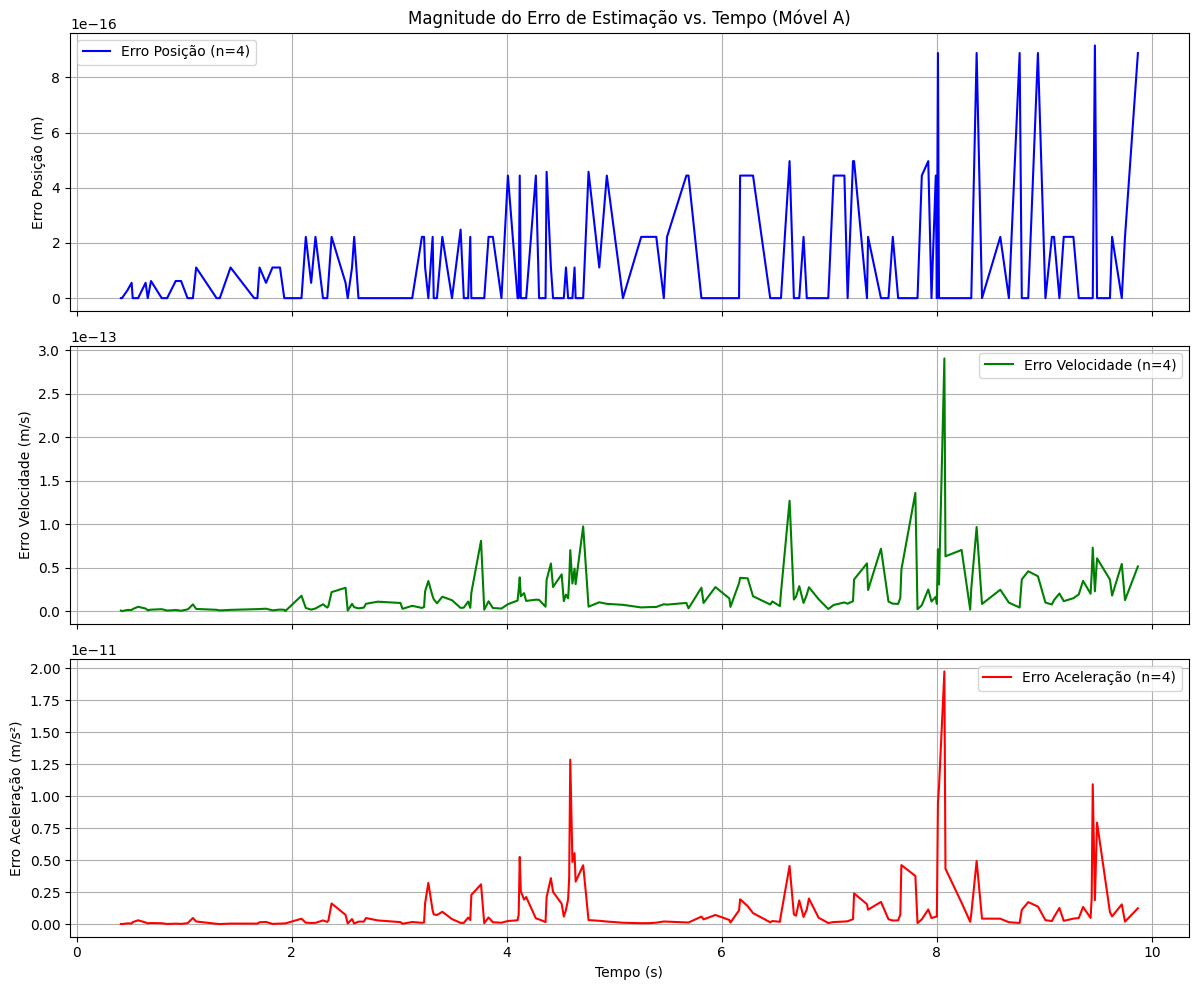

In [9]:
if tempos_err_A: # Plotar apenas se houver dados de erro
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(tempos_err_A, err_p_A, 'b-', label=f'Erro Posição (n={N_INTERP})')
    axs[0].set_ylabel('Erro Posição (m)')
    axs[0].set_title('Magnitude do Erro de Estimação vs. Tempo (Móvel A)')
    axs[0].grid(True)
    axs[0].legend()

    axs[1].plot(tempos_err_A, err_v_A, 'g-', label=f'Erro Velocidade (n={N_INTERP})')
    axs[1].set_ylabel('Erro Velocidade (m/s)')
    axs[1].grid(True)
    axs[1].legend()

    axs[2].plot(tempos_err_A, err_a_A, 'r-', label=f'Erro Aceleração (n={N_INTERP})')
    axs[2].set_ylabel('Erro Aceleração (m/s²)')
    axs[2].set_xlabel('Tempo (s)')
    axs[2].grid(True)
    axs[2].legend()
    # Pode ser útil usar escala logarítmica no eixo Y para aceleração se os erros forem grandes
    # axs[2].set_yscale('log')

    plt.tight_layout()
    plt.show()
else:
    print("\nNão foi possível plotar os erros para o Móvel A (sem dados).")

# Plotar para Móvel B também se desejar...